In [1]:
''' check GFS's Cd values from the its surface momentum flux and 10-m wind '''
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
# from coare36vn_zrf_et import coare36vn_zrf_et
# from convert_time import datetime_to_yearday
# from convert_dir import vector_dir_to_from, convert_dir_to_from
from metpy.calc import mixing_ratio_from_specific_humidity, density
from metpy.units import units
from windstr import ra_windstr_nc

In [2]:
''' GFS data info / setting '''
year = '2023'
folder_date = '20230908'
data_type = 'surface.now.'
path_model = '/Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/'
hr = 1
path_fn = path_model+folder_date+'/reg/gfs.'+folder_date+'.t00z.sfcf'+str(hr).zfill(3)+'.nc'
vars_str = ['UGRD10M','VGRD10M','UFLX_AVE','VFLX_AVE','PRESSFC','SPFH2M','TMP2M']

''' read data (there is no "holes" in the GFS model data for one file checked) '''
if os.path.isfile(path_fn):
    ds = nc.Dataset(path_fn)
    for var_str in vars_str:
        str_exec = var_str + '=ds.variables["'+var_str+'"][:]'
        exec(str_exec)
    UGRD10M = np.squeeze(UGRD10M).filled(fill_value=np.nan)
    VGRD10M = np.squeeze(VGRD10M).filled(fill_value=np.nan)
    UFLX_AVE = np.squeeze(UFLX_AVE).filled(fill_value=np.nan)
    VFLX_AVE = np.squeeze(VFLX_AVE).filled(fill_value=np.nan)
    PRESSFC = np.squeeze(PRESSFC).filled(fill_value=np.nan)
    SPFH2M = np.squeeze(SPFH2M).filled(fill_value=np.nan)
    TMP2M = np.squeeze(TMP2M).filled(fill_value=np.nan)
else:
    print('No file:',path_fn)
ds.close()

UGRD10M (202335,)
VGRD10M (202335,)


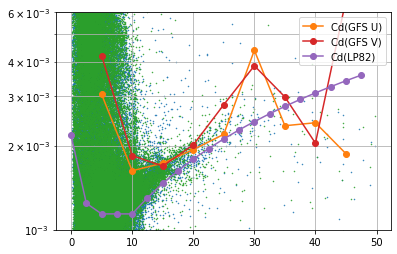

In [11]:
''' Derive Cd from GFS's surface momentum flux & U10/V10 '''
mixing_ratio = mixing_ratio_from_specific_humidity(1000*SPFH2M*units('g/kg'))
roh = np.array( density(PRESSFC*units.Pa, TMP2M*units.degK, mixing_ratio=mixing_ratio) ).flatten()
''' assuming the current velocity components are zero (b/c no surface current info in the GFS model file) '''
wndspd10M = np.sqrt( np.square(UGRD10M) + np.square(VGRD10M) ).flatten()
# plt.hist(wndspd10M.flatten(),np.arange(-5,30,1))
vars_str = ['UGRD10M','VGRD10M']
flux_str = ['UFLX_AVE','VFLX_AVE']
for v, var_str in enumerate(vars_str):
    print(var_str, eval(var_str).flatten().shape)
    data_rhs = np.abs( np.multiply( np.multiply(roh, wndspd10M),eval(var_str).flatten() ) )
    Cd = np.divide( np.abs(eval(flux_str[v])).flatten(), data_rhs )
    ''' compute bin averages '''
    bins = np.arange(2.5,50,5)
    Cd_bins = np.nan*np.ones((len(bins)-1,))
    for i in range( len(bins)-1 ):
        edge = bins[i:i+2]
        ind = np.where( (wndspd10M>= edge[0]) & (wndspd10M< edge[1]) )[0]
        # print(edge,type(ind),ind.shape)
        Cd_bins[i] = np.nanmean(Cd[ind])
    ''' plot Cd from GFS's surface momentum flux & U10/V10 '''
    plt.semilogy( wndspd10M,Cd,'.',ms=1, zorder = 1,label='' )
    plt.semilogy( 0.5*(bins[:-1]+bins[1:]), Cd_bins,'-o', zorder = 2,label='Cd(GFS '+var_str[0]+')')
''' plot Large & Pond 1982 '''
u = np.arange(0,50,2.5)
Cd_LP82 = np.nan*np.ones( u.shape )
for i in range( len(u) ):
    U = u[i]
    if U <= 1:
        Cd = 0.00218
    elif (U > 1) & (U <= 3):
        Cd = (0.62+1.56/U)*0.001
    elif (U > 3) & (U < 10):
        Cd = 0.00114;
    else:
        Cd = (0.49+0.065*U)*0.001
    Cd_LP82[i] = Cd

plt.semilogy( u, Cd_LP82, '-o',zorder=2, label='Cd(LP82)')
''' figure settings '''
plt.legend()
plt.ylim([1e-3,6e-3])
plt.grid(which='both',axis='both')

''' save figure '''
plt.savefig('check_GFS_Cd_LP82.png',dpi=400,bbox_inches='tight')